# TF Shit

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import os

# --- Configuration ---
IMG_SIZE = (28, 28)
BATCH_SIZE = 32
ALLOWED_GESTURES = ['A', 'C' ,'Q', 'T']
TRAIN_DIR = "/kaggle/input/handsignimages/Train"
VAL_DIR = "/kaggle/input/handsignimages/Test" # Using the separate folder for validation
SEED = 42

# --- 1. Augmentation Layer ---
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.04), 
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomBrightness(0.5),
    layers.RandomContrast(0.5),
    layers.RandomFlip("horizontal"),
])

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = (image / 127.5) - 1.0  # Normalize to [-1, 1]
    return image, label

# --- 2. Load and Split Dataset ---

# A. Train Subset (80% of the Train Folder)
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    class_names=sorted(ALLOWED_GESTURES),
    color_mode='grayscale',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2, # Take 20% out
    subset="training"     # This is the 80%
)

# B. Calibration/Test Subset (20% of the Train Folder)
# This is your "small chunk" for calibration and final testing
test_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    class_names=sorted(ALLOWED_GESTURES),
    color_mode='grayscale',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2, # Take same 20% out
    subset="validation"   # This is the 20%
)

# C. Validation Set (100% of the separate Test Folder)
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    label_mode='int',
    class_names=sorted(ALLOWED_GESTURES),
    color_mode='grayscale',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED,
)

# --- 3. Apply Mapping and Prefetch ---

# Apply Augmentation ONLY to train_ds
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Preprocess all (Normalization + Resize)
train_ds = train_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

# Verification prints
print(f"\nPipeline Ready:")
print(f"Train batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Val batches:   {tf.data.experimental.cardinality(val_ds)}")
print(f"Test batches:  {tf.data.experimental.cardinality(test_ds)} (Used for calibration)")

2026-02-26 07:08:52.001806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772089732.208558      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772089732.263378      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772089732.743303      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772089732.743351      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772089732.743354      55 computation_placer.cc:177] computation placer alr

Found 4735 files belonging to 4 classes.
Using 3788 files for training.
Found 4735 files belonging to 4 classes.
Using 947 files for validation.
Found 1053 files belonging to 4 classes.

Pipeline Ready:
Train batches: 119
Val batches:   33
Test batches:  30 (Used for calibration)


In [83]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_tiny_res28_deep(num_classes=4):
    inputs = layers.Input(shape=(28, 28, 1), name="input")

    # --- Initial Layer ---
    x = layers.Conv2D(16, (3, 3), padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(tf.nn.relu6)(x)

    # --- Block 1: 16 -> 32 (Spatial Reduction) ---
    x = layers.DepthwiseConv2D((3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(tf.nn.relu6)(x)
    x = layers.Conv2D(32, (1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(tf.nn.relu6)(x)
    x = layers.MaxPooling2D((2, 2))(x) # 14x14

    # --- Block 2: 32 -> 64 ---
    x = layers.DepthwiseConv2D((3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(tf.nn.relu6)(x)
    x = layers.Conv2D(64, (1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(tf.nn.relu6)(x)

    # --- Block 3-6: Four Residual Blocks at 64 Width ---
    # This is where the model gets its "Intelligence"
    for i in range(4):
        shortcut = x
        x = layers.DepthwiseConv2D((3, 3), padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(tf.nn.relu6)(x)
        
        x = layers.Conv2D(64, (1, 1), padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Add()([x, shortcut]) # Skip connection
        x = layers.Activation(tf.nn.relu6)(x)

    # --- Head ---
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_tiny_res28_deep(num_classes=4)

In [92]:
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=6.0, alpha=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[1])
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = self.alpha * tf.math.pow(1 - y_pred, self.gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=0.01)

model.compile(
    optimizer=optimizer,
    loss=FocalLoss(),
    metrics=['accuracy']
)

# Callback for Best Model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model_tf.keras", monitor='val_loss', save_best_only=True, mode='min'
)

# Learning rate scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.9156 - loss: 0.0028 - val_accuracy: 0.9696 - val_loss: 0.0017 - learning_rate: 1.0000e-04
Epoch 2/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9226 - loss: 0.0025 - val_accuracy: 0.9715 - val_loss: 0.0016 - learning_rate: 1.0000e-04
Epoch 3/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9190 - loss: 0.0022 - val_accuracy: 0.9658 - val_loss: 0.0022 - learning_rate: 1.0000e-04
Epoch 4/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9138 - loss: 0.0025 - val_accuracy: 0.9848 - val_loss: 9.2775e-04 - learning_rate: 1.0000e-04
Epoch 5/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9198 - loss: 0.0024 - val_accuracy: 0.9668 - val_loss: 0.0020 - learning_rate: 1.0000e-04


In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from scipy.optimize import minimize
import tensorflow as tf

def get_logits_and_labels(model, dataset):
    y_true = []
    y_probs = []
    
    for imgs, lbls in dataset:
        # Get standard probabilities
        probs = model.predict(imgs, verbose=0)
        y_probs.append(probs)
        y_true.append(lbls.numpy())
        
    y_probs = np.concatenate(y_probs)
    y_true = np.concatenate(y_true)
    
    # Mathematically reverse Softmax to get Logits
    # We add 1e-9 to prevent log(0) errors
    y_logits = np.log(y_probs + 1e-9)
    
    return y_logits, y_true

# Now run the rest of the calibration script!

# Get data from your calibration subset
logits, labels = get_logits_and_labels(model, test_ds)

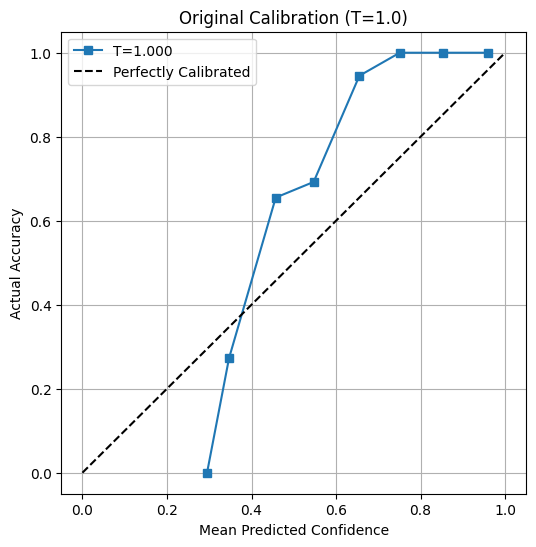

In [94]:
def plot_calibration_curve(logits, labels, temperature=1.0, title="Calibration Curve"):
    # Apply temperature and softmax
    probs = tf.nn.softmax(logits / temperature).numpy()
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    accuracies = (predictions == labels)

    # Standard calibration curve math
    prob_true, prob_pred = calibration_curve(accuracies, confidences, n_bins=10)

    plt.plot(prob_pred, prob_true, "s-", label=f"T={temperature:.3f}")
    plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
    plt.xlabel("Mean Predicted Confidence")
    plt.ylabel("Actual Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)

plt.figure(figsize=(6, 6))
plot_calibration_curve(logits, labels, temperature=1.0, title="Original Calibration (T=1.0)")
plt.show()

In [95]:
def temperature_objective(T, logits, labels):
    # T must be positive
    if T <= 0: return 1e9
    
    # Apply T to logits
    scaled_logits = logits / T
    
    # Calculate Cross Entropy Loss
    loss = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(
            labels, scaled_logits, from_logits=True
        )
    )
    return loss.numpy()

# Minimize NLL to find optimal T
result = minimize(temperature_objective, x0=1.0, args=(logits, labels), method='Nelder-Mead')
optimal_T = result.x[0]

print(f"✅ Optimal Temperature Scale: {optimal_T:.4f}")

✅ Optimal Temperature Scale: 0.3460


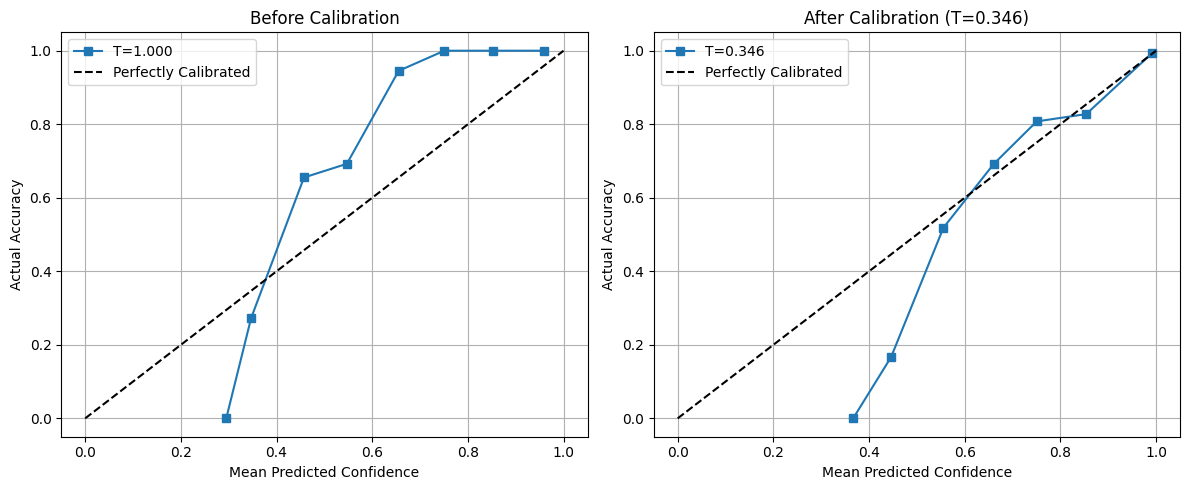

In [96]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_calibration_curve(logits, labels, temperature=1.0, title="Before Calibration")

plt.subplot(1, 2, 2)
plot_calibration_curve(logits, labels, temperature=optimal_T, title=f"After Calibration (T={optimal_T:.3f})")

plt.tight_layout()
plt.show()

In [97]:
# 1. Representative Dataset Generator
def representative_data_gen():
    # Use images from the validation set
    for input_value, _ in val_ds.take(100):
        # Already normalized and in correct shape (NHWC)
        yield [input_value[0:1]] 

# 2. Setup Converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# 3. Force Full INT8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# --- THE MAGIC FLAGS ---
# These ensure the weights are Per-Channel and Symmetric
# converter._experimental_disable_per_channel_quantization = False
# converter._experimental_new_quantizer = True 

tflite_model = converter.convert()

with open('gesture_model_esp32.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpzokrek50/assets


INFO:tensorflow:Assets written to: /tmp/tmpzokrek50/assets


Saved artifact at '/tmp/tmpzokrek50'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132448392324560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449762968784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449762980496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449762981840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449762981648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449762982992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449762980112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449762982416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449762983568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449762982224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449762969360: Tensor

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1772092231.213895      55 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1772092231.213920      55 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [38]:
biases = model.layers[-1].get_weights()[1]
print(f"Class Biases: {biases}")

Class Biases: [-0.02551783 -0.03510244  0.01686782  0.02751911]
